In [1]:
from vpolo.alevin import parser
import scanpy as sc
import pandas as pd
import os 
from scipy.io import mmwrite
from scipy.sparse import csr_matrix
import shutil
import tempfile

/opt/conda/envs/spatialdata/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/envs/spatialdata/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/spatialdata/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/spatialdata/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/spatialdata/lib/python3.10/site-packages/anndata/utils.py:429: Fut

In [2]:

# takes alevin output files as input and provides with scanpy readable matrix.mtx, barcodes.tsv and genes.tsv files

Dataset_path = "/home/jovyan/ifbdata/spatial_cell_id/Kush/alignment/demo_matrix/align"
protein_coding_file = "/home/jovyan/ifbdata/spatial_cell_id/Reference/txp2gene/protein_coding_genes_version.txt"
Matrix_output = "/home/jovyan/ifbdata/spatial_cell_id/Kush/alignment/demo_matrix/matrix"
universal_genes_file = "/home/jovyan/ifbdata/spatial_cell_id/Reference/txp2gene/genes.tsv"

with open(protein_coding_file, "r") as file:
    protein_coding_genes = {line.strip() for line in file}

for subdir in os.listdir(Dataset_path):
    subdir_path = os.path.join(Dataset_path, subdir)
    if os.path.isdir(subdir_path):
        # print(subdir_path)
        alevin_df = parser.read_quants_bin(subdir_path) 
        # print(alevin_df.shape)
        filtered_alevin_df = alevin_df.T.loc[alevin_df.T.index.isin(protein_coding_genes)] #filtering with only protein coding genes
        # print(filtered_alevin_df.shape)
        missing_genes = list(set(protein_coding_genes) - set(alevin_df.T.index)) #missing genes in df
        missing_data = pd.DataFrame(0, index=missing_genes, columns=alevin_df.T.columns) #making missing df with 0 values for all cells
        # print(missing_data.shape)
        filtered_alevin_df = pd.concat([filtered_alevin_df, missing_data]) #adding missing with 0 values
        filtered_alevin_df = filtered_alevin_df.loc[protein_coding_genes] #order sorting
        # print(filtered_alevin_df.shape)
        adata = sc.AnnData(filtered_alevin_df)
        output = os.path.join(Matrix_output, subdir)
        if not os.path.exists(output):
            os.makedirs(output)
        # matrix file
        mmwrite(os.path.join(output, "matrix.mtx"), csr_matrix(adata.X))
        
        # barcode file
        barcodes_df = pd.DataFrame(adata.var_names) #not adata.obs_names as we are using transpose matrix
        barcodes_df.to_csv(os.path.join(output, "barcodes.tsv"), sep="\t", index=False, header=False)

        # since we are using universal genes.tsv file for all datasets, putting that file in every matrix folder
        # if it was not the universal order file, we could use similar as barcodes.tsv using adata.obs_names
        # gene file
        shutil.copy(universal_genes_file, os.path.join(output, "genes.tsv"))
    # break

/home/jovyan/ifbdata/spatial_cell_id/Kush/alignment/demo_matrix/align/SRR9036396/alevin
Using rust mode with 3281 rows and 78277 columns


/tmp/ipykernel_1437368/3185371256.py:23: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  filtered_alevin_df = filtered_alevin_df.loc[protein_coding_genes] #order sorting


/home/jovyan/ifbdata/spatial_cell_id/Kush/alignment/demo_matrix/align/SRR9036397/alevin
Using rust mode with 4544 rows and 78277 columns


/tmp/ipykernel_1437368/3185371256.py:23: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  filtered_alevin_df = filtered_alevin_df.loc[protein_coding_genes] #order sorting


In [ ]:
# integrating the temp file approach:

Dataset_path = "/home/jovyan/ifbdata/spatial_cell_id/Kush/alignment/demo_matrix/align"
protein_coding_file = "/home/jovyan/ifbdata/spatial_cell_id/Reference/txp2gene/protein_coding_genes_version.txt"
Matrix_output = "/home/jovyan/ifbdata/spatial_cell_id/Kush/alignment/demo_matrix/matrix"
universal_genes_file = "/home/jovyan/ifbdata/spatial_cell_id/Reference/txp2gene/genes.tsv"

with open(protein_coding_file, "r") as file:
    protein_coding_genes = {line.strip() for line in file}

for subdir in os.listdir(Dataset_path):
    subdir_path = os.path.join(Dataset_path, subdir)
    if os.path.isdir(subdir_path):
        # print(subdir_path)
        alevin_df = parser.read_quants_bin(subdir_path) 
        # print(alevin_df.shape)
        filtered_alevin_df = alevin_df.T.loc[alevin_df.T.index.isin(protein_coding_genes)] #filtering with only protein coding genes
        # print(filtered_alevin_df.shape)
        missing_genes = list(set(protein_coding_genes) - set(alevin_df.T.index)) #missing genes in df
        missing_data = pd.DataFrame(0, index=missing_genes, columns=alevin_df.T.columns) #making missing df with 0 values for all cells
        # print(missing_data.shape)
        filtered_alevin_df = pd.concat([filtered_alevin_df, missing_data]) #adding missing with 0 values
        filtered_alevin_df = filtered_alevin_df.loc[protein_coding_genes] #order sorting
        # print(filtered_alevin_df.shape)
        adata = sc.AnnData(filtered_alevin_df)

        # same till this part, changing the output appraoch
        # removes the directory as soon as it exits the "with" loop
        with tempfile.TemporaryDirectory() as tempdir:
            # matrix.mtx
            mmwrite(os.path.join(tempdir, "matrix.mtx"), csr_matrix(adata.X))

            # barcode file
            barcodes_df = pd.DataFrame(adata.var_names) #not adata.obs_names as we are using transpose matrix
            barcodes_df.to_csv(os.path.join(tempdir, "barcodes.tsv"), sep="\t", index=False, header=False)

            # genes file
            shutil.copy(universal_genes_file, os.path.join(tempdir, "genes.tsv"))

            # scanpy input
            adata = sc.read_10x_mtx(
                tempdir,  # the directory with the `.mtx` file
                var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
                cache=False,  # disabling the automatic cache file so we can create one mannually in the training folder.
            )

In [2]:
#######
def alevin_to_scanpy(Dataset_path, protein_coding_file, universal_genes_file, metadata_file):
    with open(protein_coding_file, "r") as file:
        protein_coding_genes = {line.strip() for line in file}
    
    metadata_df = pd.read_excel(metadata_file)
    # loading the metadata file as a dataframe
    adata_dict = {} #empty dict to store adata objects 
    
    for subdir in os.listdir(Dataset_path):
        subdir_path = os.path.join(Dataset_path, subdir)
        if os.path.isdir(subdir_path):
            alevin_df = parser.read_quants_bin(subdir_path) 
            # print(alevin_df.shape)
            filtered_alevin_df = alevin_df.T.loc[alevin_df.T.index.isin(protein_coding_genes)] #filtering with only protein coding genes
            print(f"dimensions after filtering: {filtered_alevin_df.shape}")
            missing_genes = list(set(protein_coding_genes) - set(alevin_df.T.index)) #missing genes in df
            missing_data = pd.DataFrame(0, index=missing_genes, columns=alevin_df.T.columns) #making missing df with 0 values for all cells
            print(f"adding missing genes: {missing_data.shape}")
            filtered_alevin_df = pd.concat([filtered_alevin_df, missing_data]) #adding missing with 0 values
            filtered_alevin_df = filtered_alevin_df.loc[protein_coding_genes] #order sorting
            print(f"final dimension:{filtered_alevin_df.shape}")
            adata = sc.AnnData(filtered_alevin_df)

            # same till this part, changing the output appraoch
            # removes the directory as soon as it exits the "with" loop
            with tempfile.TemporaryDirectory() as tempdir:
                # matrix.mtx
                mmwrite(os.path.join(tempdir, "matrix.mtx"), csr_matrix(adata.X))

                # barcode file
                barcodes_df = pd.DataFrame(adata.var_names) #not adata.obs_names as we are using transpose matrix
                barcodes_df.to_csv(os.path.join(tempdir, "barcodes.tsv"), sep="\t", index=False, header=False)

                # genes file
                shutil.copy(universal_genes_file, os.path.join(tempdir, "genes.tsv"))

                # scanpy input
                adata = sc.read_10x_mtx(
                    tempdir,  # the directory with all three files
                    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
                    cache=False,  # disabling the automatic cache file so we can create one mannually in the training folder.
                )
                adata.var_names_make_unique()
                
                # adding metadata
                
                dataset_label = [subdir]*len(adata.obs)
                adata.obs["Dataset"]=dataset_label
                
                age_label = metadata_df.loc[metadata_df["Accession"] == subdir, "AGE"].values[0]
                adata.obs["Age"]=age_label
                
                sex_label = metadata_df.loc[metadata_df["Accession"] == subdir, "SEX"].values[0]
                adata.obs["Sex"]=sex_label

                skin_area_label = metadata_df.loc[metadata_df["Accession"] == subdir, "SKIN AREA"].values[0]
                adata.obs["Skin area"]=skin_area_label

                ethnicity_label = metadata_df.loc[metadata_df["Accession"] == subdir, "ETHNICITY"].values[0]
                adata.obs["Ethnicity"]=ethnicity_label
                
                adata_dict[subdir] = adata
    
    # adata_dict["concatenated"] = sc.concat(list(adata_dict.values()), keys=adata_dict.keys(), axis=0, label="datasets")
    return adata_dict

In [9]:
Dataset_path = "/home/jovyan/ifbdata/spatial_cell_id/Kush/alignment/sun_protected_human_skin_inguinoiliac_alevin"
protein_coding_file = "/home/jovyan/ifbdata/spatial_cell_id/Reference/txp2gene/protein_coding_genes_version.txt"
universal_genes_file = "/home/jovyan/ifbdata/spatial_cell_id/Reference/txp2gene/genes.tsv"
metadata_file = "/home/jovyan/ifbdata/spatial_cell_id/Reference/Clarins_datasets_metadata.xlsx"

output_sun_protected_human_skin_inguinoiliac = alevin_to_scanpy(Dataset_path, protein_coding_file, universal_genes_file, metadata_file)
for key in output_sun_protected_human_skin_inguinoiliac.keys():
    publication_label = ['sun_protected_human_skin_inguinoiliac']*len(output_sun_protected_human_skin_inguinoiliac[key].obs)
    output_sun_protected_human_skin_inguinoiliac[key].obs['Publication']=publication_label

/home/jovyan/ifbdata/spatial_cell_id/Kush/alignment/sun_protected_human_skin_inguinoiliac_alevin/SRR9036399/alevin
Using rust mode with 8202 rows and 78277 columns
dimensions after filtering: (20037, 8202)
adding missing genes: (79, 8202)


/tmp/ipykernel_2911836/920071750.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  filtered_alevin_df = filtered_alevin_df.loc[protein_coding_genes] #order sorting


final dimension:(20116, 8202)
/home/jovyan/ifbdata/spatial_cell_id/Kush/alignment/sun_protected_human_skin_inguinoiliac_alevin/.ipynb_checkpoints/alevin
/home/jovyan/ifbdata/spatial_cell_id/Kush/alignment/sun_protected_human_skin_inguinoiliac_alevin/.ipynb_checkpoints/alevin directory doesn't exist


SystemExit: 1

/opt/conda/envs/spatialdata/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [4]:
Concatenated_adata = sc.concat(list(output_sun_protected_human_skin_inguinoiliac.values()), axis=0)

/opt/conda/envs/spatialdata/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
Concatenated_adata = sc.concat(Concatenated_adata, list(output_sun_protected_human_skin_inguinoiliac.values()), axis=0)

In [16]:
# output['SRR9036396'].obs
output_sun_protected_human_skin_inguinoiliac

{'SRR9036396': AnnData object with n_obs × n_vars = 3281 × 20116
     obs: 'Dataset', 'Age', 'Sex', 'Skin area', 'Ethnicity', 'Publication'
     var: 'gene_ids',
 'SRR9036397': AnnData object with n_obs × n_vars = 4544 × 20116
     obs: 'Dataset', 'Age', 'Sex', 'Skin area', 'Ethnicity', 'Publication'
     var: 'gene_ids'}

In [86]:
# dataset_label = ['dataset1']*len(output_sun_protected_human_skin_inguinoiliac_alevin['SRR9036396'].obs)
# publication_label = ['sun_protected_human_skin_inguinoiliac']*len(output_sun_protected_human_skin_inguinoiliac['SRR9036396'].obs)

In [87]:
# output_sun_protected_human_skin_inguinoiliac_alevin['SRR9036396'].obs['dataset']=dataset_label
# output_sun_protected_human_skin_inguinoiliac['SRR9036396'].obs['publication']=publication_label


In [18]:
# for key in output_sun_protected_human_skin_inguinoiliac.keys():
#     print(output_sun_protected_human_skin_inguinoiliac[key].obs)
output_sun_protected_human_skin_inguinoiliac["SRR9036396"].obs

,Dataset,Age,Sex,Skin area,Ethnicity,Publication
CTTAACTTCTGAGGGA,SRR9036396,25.0,Male,sun-protected inguinoiliac region,not known,sun_protected_human_skin_inguinoiliac
AACACGTGTACAAGTA,SRR9036396,25.0,Male,sun-protected inguinoiliac region,not known,sun_protected_human_skin_inguinoiliac
AGAGCTTTCTTAACCT,SRR9036396,25.0,Male,sun-protected inguinoiliac region,not known,sun_protected_human_skin_inguinoiliac
TGGTTAGAGCAGACTG,SRR9036396,25.0,Male,sun-protected inguinoiliac region,not known,sun_protected_human_skin_inguinoiliac
CGGACGTCAACTGGCC,SRR9036396,25.0,Male,sun-protected inguinoiliac region,not known,sun_protected_human_skin_inguinoiliac
...,...,...,...,...,...,...
CAGTAACTCAGTCAGT,SRR9036396,25.0,Male,sun-protected inguinoiliac region,not known,sun_protected_human_skin_inguinoiliac
CGAGAAGAGAGCTGCA,SRR9036396,25.0,Male,sun-protected inguinoiliac region,not known,sun_protected_human_skin_inguinoiliac
CATCCACTCCAAACTG,SRR9036396,25.0,Male,sun-protected inguinoiliac region,not known,sun_protected_human_skin_inguinoiliac
CCCAGTTTCACTTACT,SRR9036396,25.0,Male,sun-protected inguinoiliac region,not known,sun_protected_human_skin_inguinoiliac


In [3]:
Concatenated_adata

AnnData object with n_obs × n_vars = 0 × 0

top 20 expressed genes for SRR9036396 - (3281, 20116)


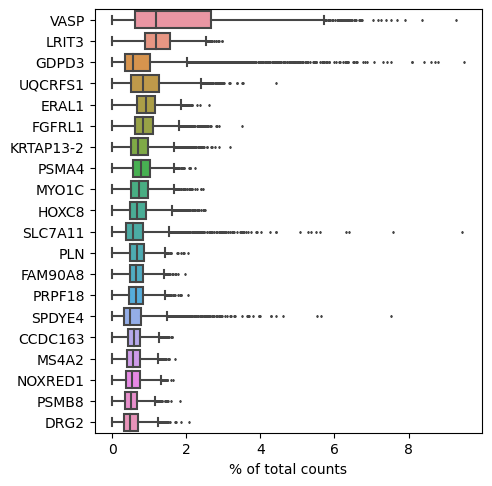

top 20 expressed genes for SRR9036397 - (4544, 20116)


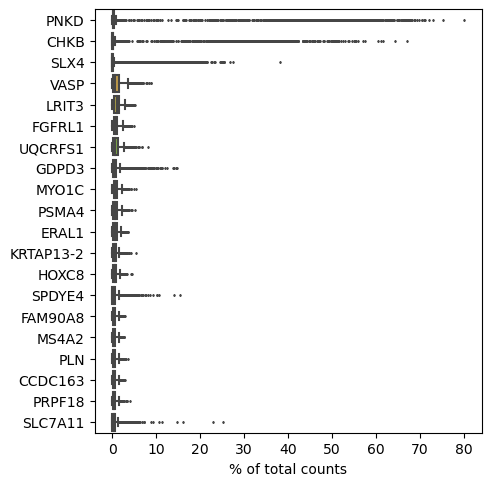

top 20 expressed genes for concatenated - (7825, 20116)


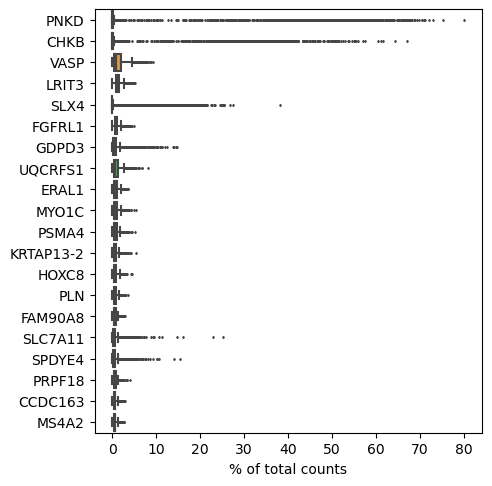

In [39]:
for dataset, adata_object in output.items():
    print(f"top 20 expressed genes for {dataset} - {adata_object.shape}")
    sc.pl.highest_expr_genes(adata_object, n_top=20)